# Model

We want to make a model where some agents move freely around while throwing some chemical into the medium where they move. The dynamics of the agents will be modelled by a Wienner process:

$$d\bold{x}_i = 0.5d\bold{W}_i$$
    
the medium receives the concentration of the agents as,
    
$$\partial_t u(x,y) = \Delta u(x,y) + \sum_{i \in \text{\{Agents\}}}\delta(x-x_i)\delta(y-y_i)$$
where $x_i$ and $y_i$ are the point positions of the agents.

# Test the parameters of integration for an appropiate integration step

Before make the hole model, we do an initial test to see in the integration parameters are good for the stable integration of the medium.

We implement a very simple medium model consisting on one component diffussing with a single static source:

$$\partial_t u(x,y) = \Delta u(x,y) + \delta(x-5)\delta(y-5)$$
where the simulation space is a box of $x\in [0,10]$ and $y\in [0,10]$.

We upload the required modules:

In [1]:
using AgentBasedModels
using Random
using Distributions
using PyPlot

And then we write the model:

In [2]:
#We define the agent, just consisting of a medium with a single source
m = @agent(2,
    u::Medium,

    UpdateMedium = begin 
        ∂t_u = (Δx(u)+Δy(u)) - u + δx(5)*δy(5)
    end,

    );
    
#Since we are using a medium, it is necessary to define the boundaries of the simulation space
s = SimulationFree(m,box=[(:x,0,10),(:y,0,10)],medium=[MediumFlat("Dirichlet",100),MediumFlat("Dirichlet",100)]);

#We compile now the model
m2 = compile(m,s);

We will try three different integration steps to check the results.

In [3]:
com = Community(m2,N=2);

com.u .= 0;

comt = m2.evolve(com, dt=0.1,tMax=10,dtSave=0.1); #We evolve with a big step
comt2 = m2.evolve(com, dt=0.01,tMax=10,dtSave=0.1); #We evolve with a big step
comt3 = m2.evolve(com, dt=0.001,tMax=10,dtSave=0.1); #We evolve with a smaller step

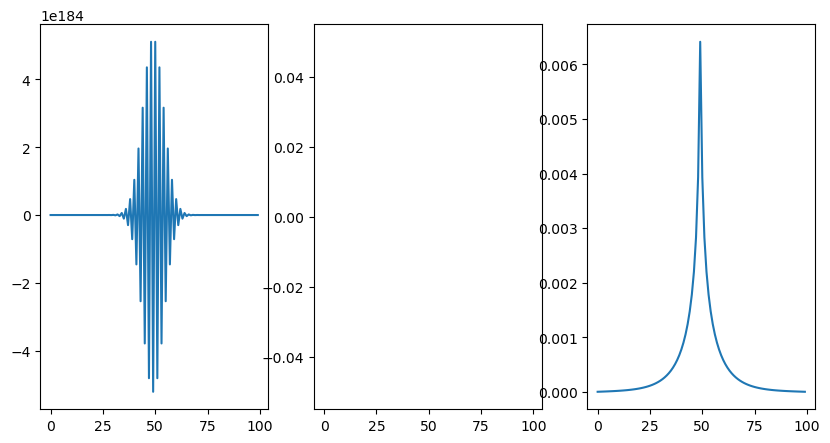

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fb6290cbdf0>

In [4]:
fig,ax = plt.subplots(1,3,figsize=[10,5])

ax[1].plot(comt[end].u[:,50])
ax[2].plot(comt2[end].u[:,50])
ax[3].plot(comt3[end].u[:,50])

The second step does not show, we check what happened with it.

In [5]:
println(comt2[end].u[:,50])

[0.0, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, 0.0]


Clearly, an step so big as `dt=0.1` and `dt=0.01` are giving unrealistic results. For the integrator that we are using we have to to choose the integration step as small as `dt=0.001`.

# Create the actual model

With the integration parameter chosen, we implement the full model.

In [6]:
m = @agent(2,
    p::Local,
    [u,v]::Medium,

    Equation = begin
        d_x = 0.5*dW
        d_y = 0.5*dW
    end,

    UpdateMedium = begin 
        ∂t_u = (Δx(u)+Δy(u)) - u
    end,

    UpdateMediumInteraction = begin
        u += p
    end

    );
    
s = SimulationFree(m,box=[(:x,0,10),(:y,0,10)],medium=[MediumFlat("Dirichlet",100),MediumFlat("Dirichlet",100)]);

m2 = compile(m,s);

In [7]:
com = Community(m2,N=2);

com.x .= [5,5.1]
com.y .= 5
com.p .= 1.
com.u .= 0;

comt = m2.evolve(com, dt=0.001,tMax=10,dtSave=0.1);

# Make video of the process

In [14]:
using PyPlot
using PyCall
an = pyimport("matplotlib.animation") #we use this for the creation of the animation

PyObject <module 'matplotlib.animation' from '/usr/lib/python3.9/site-packages/matplotlib/animation.py'>

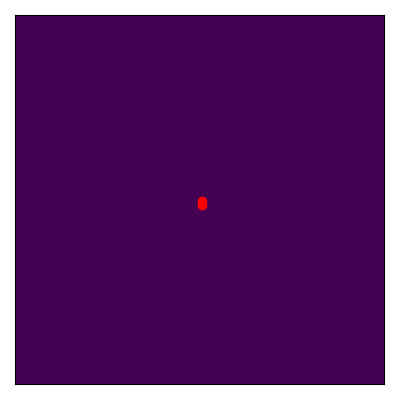

PyObject <matplotlib.animation.FuncAnimation object at 0x7fb628739e50>

In [16]:
fig,ax = PyPlot.subplots(1,1)
global ln1 = ax.matshow(comt[1].u)
global ln2 = ax.scatter((comt[1].y.+0).*100/10,(comt[1].x.+0).*100/10,color="red") #Inverted as matshow gives the matrix transposed
global comt2 = comt

ln1.set_clim(0,maximum(comt[end].u))
ax.set_xticks([])
ax.set_yticks([])

function plotInTime(i)

    ln1.set_data(comt[i].u)
    ln2.set_offsets(hcat((comt2[i].y.+0).*100/10,(comt2[i].x.+0).*100/10))

end

im = an.FuncAnimation(fig,plotInTime,2:100)
# im.save("im.gif")